In [15]:
import numpy as np
import numpy
import xarray as xr
import matplotlib.pyplot as plot


In [6]:
def normalize_axis(axis,ndim):
    
    # axis is either a scalar or iterable. 
    #
    try:
        iterator = iter(axis)
    except TypeError:
        # not iterable
        axis = [axis]
  
    
    axis = [x if x >= 0 else ndim+x for x in axis]
    
    return axis

In [7]:
def read_var(file, ftype, varname, ts, dims=[1,1,1]):
    print('file = ', file)
    if ftype == "netcdf":
        ds = xr.open_dataset(file, decode_times=False)
        data = ds.get(varname).isel(time=ts).values
    else:
        nelements = np.prod(dims)
        data = np.fromfile(file, dtype=np.float32, count=nelements)
        data = np.squeeze(data.reshape(dims))

    return (data)

In [8]:
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''

    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)

In [9]:
def autocorr2(x,lags):
    '''manualy compute, non partial'''

    mean=numpy.mean(x)
    var=numpy.var(x)
    xp=x-mean
    corr=[1. if l==0 else numpy.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]

    return numpy.array(corr)


In [10]:
#
# FFT-based autocorrelation with padding
# 
def autocorr3(x,lags,axis=-1):
    '''fft, pad 0s, non partial'''

    n=x.shape[axis]
    # pad 0s to 2n-1
    ext_size=2*n-1
    # nearest power of 2
    fsize=2**numpy.ceil(numpy.log2(ext_size)).astype('int')

    xp=x-numpy.mean(x,axis=axis,keepdims=True)
    var=numpy.var(x,axis=axis,keepdims=True)

    # do fft and ifft
    cf=numpy.fft.fft(xp,fsize,axis=axis)
    sf=cf.conjugate()*cf
    corr=numpy.fft.ifft(sf,axis=axis).real
    corr = np.divide(corr,var,where=(var!=0.0))
    corr = corr / n
   
    naxis = tuple(set(np.arange(x.ndim).tolist()) - set(normalize_axis(axis,x.ndim)))
    
    return np.mean(corr,axis=naxis)[:len(lags)]



In [11]:
def autocorr4(x,lags):
    '''fft, don't pad 0s, non partial'''
    mean=x.mean()
    var=numpy.var(x)
    xp=x-mean

    cf=numpy.fft.fft(xp)
    sf=cf.conjugate()*cf
    corr=numpy.fft.ifft(sf).real/var/len(x)
    

In [12]:
def autocorr5(x,lags):
    '''numpy.correlate, non partial'''
    mean=x.mean()
    var=numpy.var(x)
    xp=x-mean
    corr=numpy.correlate(xp,xp,'full')[len(x)-1:]/var/len(x)

    return corr[:len(lags)]

(64, 64)


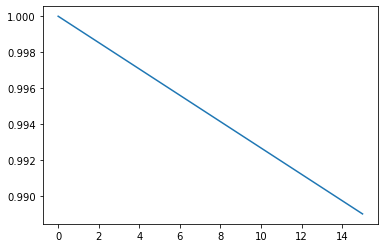

In [13]:
import matplotlib.pyplot as plot

t = np.arange(0, 64*64, 1,dtype=np.float32) / 64.0 * np.pi * 25.0
s = np.sin(t).reshape(64,64)

print (s.shape)
n = 16
lags = range(n)

plot.plot(autocorr3(t,lags,axis=-1))



In [37]:
file = '/Users/clyne/Data/CAM/AMIP_0.25degree/cam5_1_amip_run2.cam2.h1.1979-01-01-00000.nc'



ds = xr.open_dataset(file, decode_times=False)
for varname in ds.data_vars:

    if ds[varname].ndim == 3:
        data = ds.get(varname).isel(time=0).values
        
        lags=range(4)

        # print 4-lag autocorrelation. Note lag=0 should be ~1.0
        print (varname, ' ', np.min(data), ' ', np.max(data))
        for d in (0,1):
            print('        ', 'dim =', d, ' ', autocorr3(data,lags,axis=d))





CLDTOT   0.0   1.0
         dim = 0   [0.99999996 0.87487303 0.76533522 0.68190394]
         dim = 1   [0.99869905 0.89372246 0.79388989 0.71467519]
FLDS   94.57982   459.7665
         dim = 0   [0.99999999 0.98678879 0.97468588 0.96366206]
         dim = 1   [1.         0.95852748 0.92165327 0.88889622]
FLDSC   94.16072   431.92297
         dim = 0   [1.00000001 0.99632354 0.99179718 0.98696969]
         dim = 1   [1.         0.99268171 0.9794218  0.96418709]
FLNS   -80.99102   435.33313
         dim = 0   [1.00000002 0.95611181 0.91626015 0.8821644 ]
         dim = 1   [1.         0.94786605 0.89823612 0.85454549]
FLUT   80.489204   374.09515
         dim = 0   [1.00000002 0.97721298 0.94316017 0.90783344]
         dim = 1   [1.         0.96967847 0.92413242 0.87539718]
FLUTC   173.52068   376.0187
         dim = 0   [1.         0.99505005 0.9885495  0.9818061 ]
         dim = 1   [1.         0.9890874  0.97100861 0.95109461]
FSDS   0.0   1104.7214
         dim = 0   [0.99999993 0.98